# Feature Selection with the D-Wave System
Placeholder sentence: In the [feature selection demo](<<< leap_url >>>/demos/socialnetwork/) you saw ...   

This notebook examines how you can solve optimization problems on a  D-Wave quantum processing unit (QPU) with the example of a feature-selection problem.
    
1. [What is Feature Selection?](#What-is-Feature-Selection?) defines and explains the feature-selection problem.
2. [Feature Selection by Mutual Information](#Feature-Selection-by-Mutual-Information) describes a particular method of feature selection that is used in this notebook.
3. [Solving Feature Selection on a Quantum Computer](#Solving-Feature-Selection-on-a-Quantum-Computer) shows how such optimization problems can be formulated for solution on a quantum computer. 
4. [Example Application: Predicting Survival of Titanic Passangers](#Example-Application:-Predicting-Survival-of-Titanic-Passangers) uses feature selection on a known problem. 

This notebook should help you understand both the techniques and [Ocean software](https://github.com/dwavesystems) tools used for solving optimization problems on D-Wave quantum computers.

**New to Jupyter Notebooks?** JNs are divided into text or code cells. Pressing the **Run** button in the menu bar moves to the next cell. Code cells are marked by an "In: \[\]" to the left; when run, an asterisk displays until code completion: "In: \[\*\]".

# What is Feature Selection?
Statistical and machine-learning models use a set of input variables (features)
to predict output variables of interest. Feature selection, which can be
part of the model design process, simplifies the model and reduces dimensionality by selecting,
from a given set of potential features, a subset of highly informative ones. 

For example, if Farmer Jones were creating a model for predicting the ripening of her hothouse tomatoes, she might start recording daily the following list of potential features: date, air temperature, degree of cloudiness, hours of daylight, daily water, fertilizer, air humidity, hours of electric light, ambient music style. After a growth season or two, she analyzes correlations between these features and her tomato crops. Her analysis reveals:

* date, cloudiness, daylight have little predictive power
* water and humidity are highly predictive of crop rot; they are also highly correlated (the hothouse has a roof sprinkler) 
* fertilizer is highly predictive of fruit size

Farmer Jones understands that her hothouse's electric light makes her crop less dependant on seasons (date) and sunshine (cloudiness). She can simplify her model by disregarding those features. She can also reduce the number of inputs by recording either her water or humidity measurement but not both.

For systems with large amounts of potential input information, such as weather forecasting or facial recognition, the model complexity and required compute resources can be daunting. Feature selection can help make such models tractable. 

However, optimal feature selection itself can be a hard problem. This example introduces a powerful method of optimizing feature selection based on a hard probability calculation. To overcome the difficulties of this calculation, it formulates a solution by quantum computer.  

## Illustrative Toy Problem
This section illustrates the use of feature selection with a very simple example.

An example system has a single output that is generated by three inputs. The model then used to predict the output is even simpler than the system, with just two features. If all three inputs contribut somewhat commensurately* to the output, the model should perform better if the selected features are more independant. If this was a model of Farmer Jones's tomatoes, selecting water and fertilizer should be better than water and humidity.

*: If an independant input contributes less than the difference between two correlated ones, this might not be true. 

The next cell creates three inputs, two of which are very similar---a sine and a noisy sine---and one that is linear with added random noise.  For simplicity, the output is a linear combination of the three inputs. 

In [1]:
import numpy as np
import pandas as pd

# Three features: in1 & in2 are similar; in3 is different 
in1 = np.sin(np.linspace(-np.pi, np.pi, 100)).reshape(100,1)
in2 = np.sin(np.linspace(-np.pi+0.1, np.pi+0.2, 100)).reshape(100,1) + 0.3*np.random.rand(100, 1)
in3 = np.linspace(-1, 1, 100).reshape(100,1) + 2*np.random.rand(100, 1)

# Variable of interest's relationship to the features
out = 2*in1 + 3*in2 + 6*in3

# Store all in a pandas DataFrame for later use
toy = pd.DataFrame(np.hstack((in1, in2, in3, out)), columns=["in1", "in2", "in3", "out"])

The next cell plots the features (three inputs) and the variable of interest (the output). You can see that inputs 1 and 2 are much more correlated to each other than either of those two are correlated to input 3.

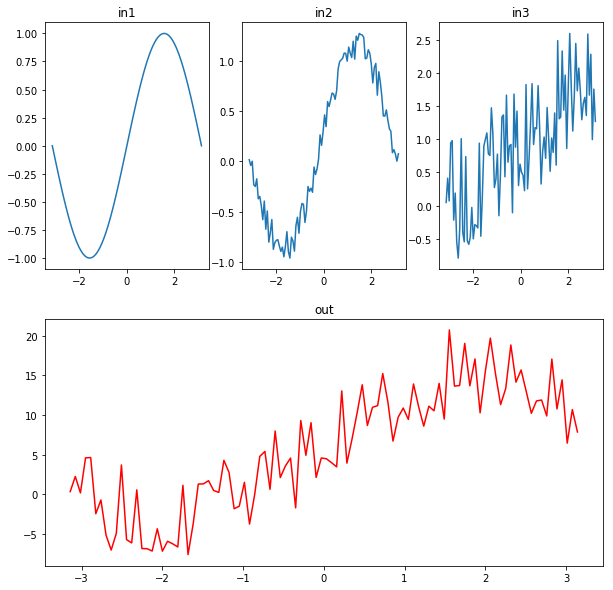

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from helpers.plots import subplot_xx_y
subplot_xx_y(toy)

The next cell defines a simple linear model of only two variables. It uses SciPy's `curve_fit` function to try to reproduce the variable of interest using first the two correlated features (inputs 1 and 2) and then two disimilar features (inputs 1 and 3). It prints for both models a measure of the statistical error in the fitting for comparison.

The next cell plots comparison graphs between the outputs generated by both two-variable models and the output of the system. You can see that the second model, which uses two less correlated inputs, performs better.

Standard deviation for selection of features in1 and in2 is 2.8584.
Standard deviation for selection of features in1 and in3 is 0.0842.
Standard deviation for selection of features in2 and in3 is 0.0588.


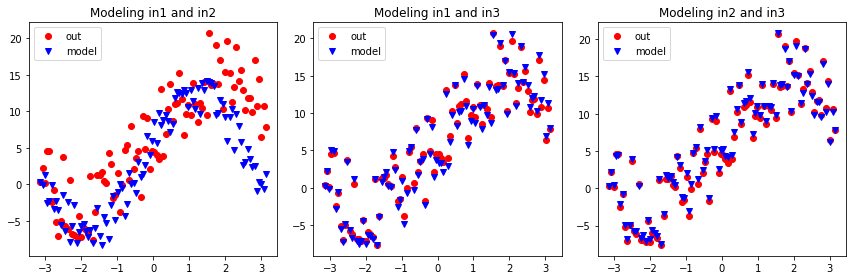

In [3]:
import itertools
from scipy.optimize import curve_fit

# Define a simple two-variable model
def two_var_model(IN, a, b):
    ina, inb = IN
    return a*ina + b*inb

#from helpers.plots import plot_vars_out
#plot_vars_out(toy, ['in1', 'in2', popt_12], ['in1', 'in3', popt_13], out, two_var_model) 

i = 1
plt.figure(figsize=(12, 4))
for f0, f1 in itertools.combinations(['in1', 'in2', 'in3'], 2):
    popt, pcov = curve_fit(two_var_model, (toy[f0].values, toy[f1].values), toy['out'].values)
    print("Standard deviation for selection of features {} and {} is {:.4f}.".format(f0, f1, max(np.sqrt(np.diag(pcov)))))
    #plot_vars_out(toy, ['in1', 'in2', popt_12], ['in1', 'in3', popt_13], out, two_var_model)
    ax = 'ax_' + str(i)
    ax = plt.subplot(1, 3, int(i))    
    ax.set_title("Modeling %s and %s" % (f0, f1))
    ax.plot(np.linspace(-np.pi, np.pi, 100), toy['out'].values, 'ro')
    ax.plot(np.linspace(-np.pi, np.pi, 100), two_var_model((toy[f0].values, toy[f1].values), popt[0], popt[1]), 'bv')
    ax.legend(["out", "model"])
    i += 1
plt.tight_layout()

The following sections can help you benefit from the advantages of optimal feature selection in modeling more complex systems.

# Feature Selection by Mutual Information
There are many methods to do feature selection. For example, if you are building a deep learning network and have six potential features, you might try training first on each of the features by itself, then on all 15 combinations of subsets of two features, then 20 combinations of subsets of three features, and so on. This naive method rarely works for real-world cases. For those, statistical methods are much more efficient.  

One statistical criterion that can guide this selection is mutual information (MI). The following subsections explain information and MI.

If you already understand mutual information and Shannon entropy, please skip to section [Solving Feature Selection on a Quantum Computer](#Solving-Feature-Selection-on-a-Quantum-Computer). 

## Quantifying Information: Shannon Entropy
How does Shannon entropy (SE) quantify information in a signal? $H(X)$, a measure of information in a signal

$H(X) = - \sum_{x \in X} p(x) \log p(x)$

The formula for SE can be viewed as weighing the possible values $\log \frac{1}{p(x)}$ by the probability of occurring, $p(x)$. **Some more explanation here...**

To calculate SE, this section defines a probablity function that takes the data of some variables (this would be training data in a machine learning context) and divides it into bins to map the probability of any data point (as a statistical event).

In [4]:
def prob(dataset, max_bins=10):
    """Joint probability distribution P(X) for the given data."""

    # bin by the number of different values per feature
    num_rows, num_columns = dataset.shape
    bins = [min(len(np.unique(dataset[:, ci])), max_bins) for ci in range(num_columns)]

    prob, _ = np.histogramdd(dataset, bins)
    return prob / np.sum(prob)

def shannon_entropy(p):
    """Shannon entropy H(X) is the sum of P(X)log(P(X)) for probabilty distribution P(X)."""
    p = p.flatten()
    return -sum(pi*np.log2(pi) for pi in p if pi)

### Illustration of Shannon Entropy
To see an intuitive example of measuring SE, this subsection applies it to three signals with defined distributions:

* Uniform: all outcomes are equally likely, or unpredictable, so maximal values of SE occur for uniform distribution: $H(X) = log(N)$ where $N$ is the number of possible outcomes, ${x_1, x_2, ...x_N}$. 
* Exponential: for increasing on curve steepness, an outcome further along the tail has increasing probability, so lower information for more of the outcomes. 
* Unequal probabilities: outcomes with higher probabilities have lower information&mdash;on average, we're learning less from each event. Biasing this signal strongly to one outcome means most the time the signal is predictable, or low in information. $H(X) = -p \log(p) - (1-p) \log(1-p)$ so for $p = 0.1$, for example, $H(X) = 0.468$.  

Text(0, 0.5, 'Entropy')

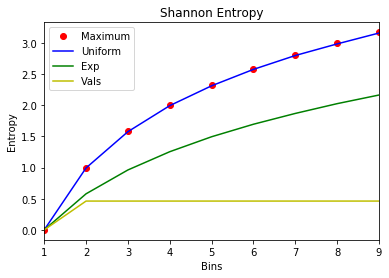

In [5]:
data = list()
max_bins = 10
x_uniform = np.random.uniform(0, 1, (1000, 1))
x_exp = np.exp(-np.linspace(0, 10, 1000)/2).reshape(1000, 1)
x_vals = np.random.choice([0, 1],(1000, 1), p=[0.1, 0.9])
for bins in range(1, max_bins):
    uniform_se = shannon_entropy(prob(x_uniform, bins))
    exp_se = shannon_entropy(prob(x_exp, bins))
    vals_se = shannon_entropy(prob(x_vals, bins))                               
    data.append({'Bins': bins, 'Uniform': uniform_se, 'Maximum': np.log2(bins), 'Exp': exp_se, 'Vals': vals_se})
pd.DataFrame(data).plot(x='Bins', y=['Maximum', 'Uniform', 'Exp', 'Vals'], style = [ 'ro','b', 'g', 'y']) 
plt.title("Shannon Entropy")
plt.ylabel("Entropy")

### Conditional Shannon Entropy

Conditional SE measures the information in a signal, $X$, if the value of signal $Y$ is known: 

$\begin{aligned} H(X|Y) 
& = H(X,Y)-H(Y) \\
& = - \sum_{x \in X} p(x, y) \log p(x, y) - H(Y) \end{aligned}$

where $H(X,Y)$, the joint SE, measures the information in both signals $X$ and $Y$ together, and $p(x,y)$ is the joint probability. 

In [6]:
def conditional_shannon_entropy(p, *conditional_indices):
    """entropy of P conditional on variable j"""

    axis = tuple(i for i in np.arange(len(p.shape)) if i not in conditional_indices)

    return shannon_entropy(p) - shannon_entropy(np.sum(p, axis=axis))

Apply CSE to the toy problem. Signals `in1` and `in2` are very similar, and knowing the value of one provides a good estimate of the value of the other. In contrast, the value of signal `in3` provides a less accurate estimate of the first two.  

Text(0, 0.5, 'Entropy of in1 Conditional on Inputs')

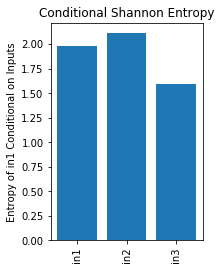

In [7]:
cse = {}
for column in toy.columns:

    if column == 'out':
        continue
    
    cse[column] = conditional_shannon_entropy(prob(toy[["out", column]].values), 1)

labels, values = zip(*cse.items())

plt.subplot(1, 2, 1)
plt.bar(np.arange(len(labels)), values)
plt.xticks(np.arange(len(labels)), labels, rotation=90)
plt.title("Conditional Shannon Entropy")
plt.ylabel("Entropy of in1 Conditional on Inputs")

From from looking at the input and output signals in the first section it seems surprising that `in3` is more informative than the two sine signals, you can run a linear regression to verify this result. 

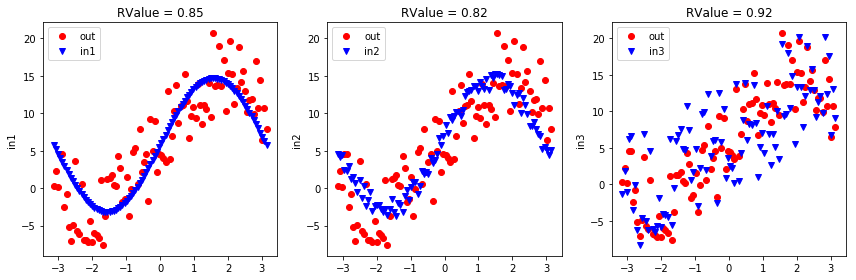

In [8]:
from scipy.stats import linregress

plt.figure(figsize=(12, 4))
for column in toy.columns:

    if column == 'out':
        continue

    slope, intercept, rvalue, *_ = linregress(toy[column].values, toy['out'].values)
    
    i = next(char for char in column if char.isdigit())
    ax = 'ax_' + i
    ax = plt.subplot(1, 3, int(i))
    ax.plot(np.linspace(-np.pi, np.pi, 100), toy['out'].values, 'ro')
    ax.plot(np.linspace(-np.pi, np.pi, 100), slope*toy['in'+i].values + intercept, 'bv')
    ax.set_title("RValue = {:.2f}".format(rvalue))
    ax.set_ylabel(column)
    ax.legend(["out", column])
plt.tight_layout()

## Mutual Information
At a high level, MI quantifies how much one knows about one random variable from observations of another variable. Intuitively, if two features have high MI, a model based on just one of the features should be closer to a model based on both compared to features with low MI. 

MI between variables $X$ and $Y$, is defined as 

$I(X;Y)  = \sum_{y \in Y} \sum_{x \in X} p(x, y) \log \frac{p(x,y)}{p(x)p(y)}$

where $p(x)$ and $p(y)$ are marginal probabilities of $X$ and $Y$, and $p(x,y)$ the joint probability. Equivalently, 

$I(X;Y)  = H(Y) - H(Y|X)$

where $H(Y)$ is the SE of $Y$ and $H(Y|X)$ is the CSE of $Y$ conditional on $X$.

In [9]:
def mutual_information(prob, j):
    """mutual information between all variables and variable j"""
    return shannon_entropy(np.sum(prob, axis=j)) - conditional_shannon_entropy(prob, j)

### MI on the Toy Problem

Text(0, 0.5, 'MI of in1 and input')

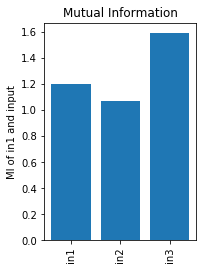

In [10]:
scores = {}
for column in toy.columns:

    if column == 'out':
        continue

    scores[column] = mutual_information(prob(toy[['out', column]].values), 0)

labels, values = zip(*scores.items())

plt.subplot(1, 2, 1)
plt.bar(np.arange(len(labels)), values)
plt.xticks(np.arange(len(labels)), labels, rotation=90)
plt.title("Mutual Information")
plt.ylabel("MI of in1 and input")

### Conditional Mutual Information

$I(X_j;Y |X_i)$ represents conditional MI between the output variable and a feature given the selection of another feature

Last, the next cell defines 

In [11]:
def conditional_mutual_information(p, j, *conditional_indices):
    """Mutual information between variables X and variable Y conditional on variable Z.
    Calculated as I(X;Y|Z) = H(X|Z) - H(X|Y,Z)"""

    return conditional_shannon_entropy(np.sum(p, axis=j), *conditional_indices) - conditional_shannon_entropy(p, j, *conditional_indices)

### CMI on the Toy Problem

Text(0.5, 1.0, 'Conditional Mutual Information')

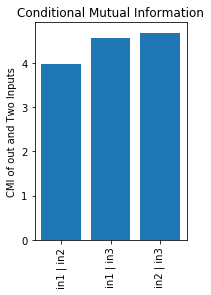

In [12]:
import itertools
cmi = {}

for f0, f1 in itertools.combinations(['in1', 'in2', 'in3'], 2):
    cmi[(f0, f1)] = conditional_mutual_information(prob(toy[['out', f0, f1]].values), 1, 2)

labels, values = zip(*cmi.items())

plt.subplot(1, 2, 1)
plt.bar(np.arange(len(labels)), values)
plt.xticks(np.arange(len(labels)), [label[0]+" | "+label[1] for label in labels], rotation=90)
plt.ylabel("CMI of out and Two Inputs")
plt.title("Conditional Mutual Information")

Ideally, to select the $k$ most relevant features of $n$ for a model, you could maximize $I({X_s}; Y)$, the MI between a set of $k$ features, $X_s$, and the output variable of interest, $Y$. This is a hard calculation because $n \choose k$ grows rapidly in real-world problems.

# Solving Feature Selection on a Quantum Computer
There are different methods of approximating the hard calculation of $n \choose k$ features based on maximizing MI. One approach assumes conditional independence of the features and limits MI calculations to sets of three features. The optimal set of features is then given by:

$\frac{1}{k} \arg \max_s \sum_{i=1}^n \left \{ I(X_i;Y) + \sum_{j \in s|_i} I(X_j;Y |X_i) \right \}$


The lefthand component, $I(X_i;Y)$, represents MI between the output variable and a particular feature; maximizing means selecting features that are highly predictive of the output. The righthand component, $I(X_j;Y |X_i)$, represents conditional MI between the output variable and a feature given the selection of another feature; maximizing means selecting features that complement information about the output variable rather than provide redundant information.

This approximation is still a hard calculation; this section demonstrates a method for formulating it for solution on the D-Wave quantum computer. 

## MIQUBO
D-Wave systems solve binary quadratic models (BQM), the Ising model traditionally used in statistical mechanics and its computer-science equivalent, the quadratic unconstrained binary optimization (QUBO) problem. Given $N$ variables $x_1,...,x_N$, where each variable $x_i$ can have binary values $0$ or $1$, the system finds assignments of values that minimize,
    
$\sum_i^N q_ix_i + \sum_{i<j}^N q_{i,j}x_i  x_j$,
    
where $q_i$ and $q_{i,j}$ are configurable (linear and quadratic) coefficients. To formulate a problem for the D-Wave system is to program $q_i$ and $q_{i,j}$ so that assignments of $x_1,...,x_N$ also represent solutions to the problem.

For feature selection, the Mutual Information QUBO (MIQUBO) method formulates a QUBO based on the approximation above for $I({X_s}; Y)$, which is submitted to the D-Wave quantum computer for solution.



## Formulating a QUBO
The approximation above for optimal feature selection, with its limitation on calculating MI to sets of three variables, is a natural fit for QUBO formulation. 

<table style="width:70%">
  <tr>
    <th width="50%">Formula</th>
    <th width="10%">Optimization</th> 
    <th width="15%">Linear terms</th>
    <th width="15%">Quadratic terms</th>
  </tr>
  <tr>
      <td><b>Feature Selection</b>: $\sum_{i=1}^n \left \{ I(X_i;Y) + \sum_{j \in s|_i} I(X_j;Y |X_i) \right \}$</td>
    <td>Maximize</td> 
    <td>$I(X_i;Y)$</td>
    <td>$I(X_j;Y |X_i)$</td>
  </tr>
  <tr>
    <td><b>QUBO</b>: $\sum_i^N q_ix_i + \sum_{i<j}^N q_{i,j}x_i  x_j$</td>
    <td>Minimize</td> 
    <td>$q_ix_i$</td>
    <td>$q_{i,j}x_ix_j$</td>
  </tr>
</table>

Because the quantum computer seeks to minimize the programmed problem, these terms of the feature-selection formula should be set negative in the QUBO.   



To represent a choice of $k$ features out of a set of $n$, it makes sense that the assignments of $x_1,...,x_N$, which represent solutions to the problem, set $x_i$ to $1$ if feature $X_i$ should be selected and to $0$ if not. 

With solutions encoded this way, you can represent the QUBO in matrix format, 

$\mathbf{x}^T \mathbf{Q x}$

where $\mathbf Q$ is an $n$ X $n$ matrix and $\mathbf{x}$ is an $n$ x $1$ matrix (a vector) that should have $k$ ones representing the best features. To map the approximation above to a QUBO, the diagonal elements of $\mathbf Q$, representing linear coefficients, should minimize MI between the output and each feature, $Q_{ii} \leftarrow -I(X_i;Y)$, and non-diagonal elements, representing quadratic elements of $\mathbf Q$, should minimize for pairs of features that complement information about the output variable rather than provide redundant information, $Q_{ij} \leftarrow -I(X_j;Y |X_i)$.



### A QUBO on the Toy Problem

Create a BQM and set the linear coefficients: the MI between `out` and each potential feature. 

In [13]:
import dimod
bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

for column in toy.columns:

    if column == 'out':
        continue

    mi = mutual_information(prob(toy[['out', column]].values), 1)
    bqm.add_variable(column, -mi)

print(bqm.linear)

{'in1': -1.2007425694054974, 'in2': -1.0676369490625426, 'in3': -1.5902162939379156}


Add the quadratic coefficients: the MI between `out` and each potential feature conditional on the other features.

In [14]:
for f0, f1 in itertools.combinations(['in1', 'in2', 'in3'], 2):
    cmi[(f0, f1)] = conditional_mutual_information(prob(toy[['out', f0, f1]].values), 1, 2)
    mi = conditional_mutual_information(prob(toy[['out', f0, f1]].values), 1, 2)
    bqm.add_interaction(f0, f1, -mi)

bqm.normalize()

print(bqm.quadratic)

{('in1', 'in2'): -0.8506656272498854, ('in1', 'in3'): -0.9770271585657757, ('in2', 'in3'): -1.0}


In [15]:
sampler = dimod.reference.samplers.ExactSolver()

result = sampler.sample(bqm)
print(result)

  in1 in2 in3    energy num_oc.
5   1   1   1 -3.651903       1
6   1   0   1 -1.573186       1
4   0   1   1 -1.567727       1
2   1   1   0   -1.3352       1
7   0   0   1 -0.339676       1
1   1   0   0 -0.256483       1
3   0   1   0 -0.228051       1
0   0   0   0       0.0       1
['BINARY', 8 rows, 8 samples, 3 variables]


The best solution is when all three input signals are used. Next best, when only two are used, include `in3`.

At this point, the mapping does not include any requirement on the number of selected features. 

### Penalizing $len(s) != k$
How do you represent the requirement that only $k$ features be selected? By penalizing solutions with more or less than $k$ ones:

$P = \alpha \sum_{i=1}^n ( x_i - k)^2$ 

where $P$ is the penalty. 

In [16]:
k = 2
bqm.update(dimod.generators.combinations(bqm, k, strength=6))

result = sampler.sample(bqm)
print(result)

  in1 in2 in3 energy num_oc.
6   1   0   1 -1.573186       1
4   0   1   1 -1.567727       1
2   1   1   0 -1.3352       1
5   1   1   1 2.348097       1
7   0   0   1 5.660324       1
1   1   0   0 5.743517       1
3   0   1   0 5.771949       1
0   0   0   0   24.0       1
['BINARY', 8 rows, 8 samples, 3 variables]


# Example Application: Predicting Survival of Titanic Passangers
This example illustrates the MIQUBO method by finding an optimal feature set for predicting survival of Titanic passengers. It uses records provided in file formatted_titanic.csv, which is a feature-engineered version of a public database of passenger information recorded by the ship's crew (in addition to a column showing survival for each passenger, it contains information on gender, title, class, port of embarkation, etc). Its output is a ranking of subsets of features that have
high MI with the variable of interest (survival) and low redundancy.

In [18]:
titanic = pd.read_csv("data\\formatted_titanic.csv")

<BarContainer object of 14 artists>

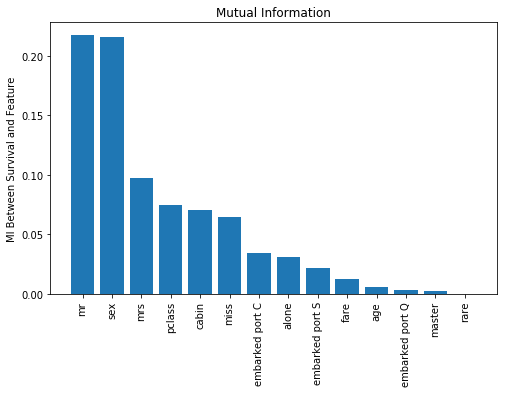

In [33]:
scores = {}
features = list(set(titanic.columns).difference(('survived',)))
for feature in features:
    scores[feature] = mutual_information(prob(titanic[['survived', feature]].values), 0)

labels, values = zip(*sorted(scores.items(), key=lambda pair: pair[1], reverse=True))

plt.figure(figsize=(8, 5))
plt.title("Mutual Information")
plt.ylabel('MI Between Survival and Feature')
plt.xticks(np.arange(len(labels)), labels, rotation=90)
plt.bar(np.arange(len(labels)), values)

In [34]:
features = list(set(titanic.columns).difference(('survived',)))

bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

# add the features
for feature in features:
    mi = mutual_information(prob(titanic[['survived', feature]].values), 1)
    bqm.add_variable(feature, -mi)


for f0, f1 in itertools.combinations(features, 2):
    mi = conditional_mutual_information(prob(titanic[['survived', f0, f1]].values), 1, 2)
    bqm.add_interaction(f0, f1, -mi)

bqm.normalize()  # to -1, 1

In [35]:
from dwave.embedding.chimera import find_clique_embedding
from dwave.system import DWaveSampler, FixedEmbeddingComposite
 
qpu_sampler = DWaveSampler(solver={'qpu': True})

embedding = find_clique_embedding(bqm.variables,
                                  16, 16, 4,  # size of the chimera lattice
                                  target_edges=qpu_sampler.edgelist)

sampler = FixedEmbeddingComposite(qpu_sampler, embedding)


selected_features = np.zeros((len(features), len(features)))
for k in range(1, len(features) + 1):
    kbqm = bqm.copy()
    kbqm.update(dimod.generators.combinations(bqm, k, strength=6))

    sample = sampler.sample(kbqm, num_reads=10000).first.sample

    for fi, f in enumerate(features):
        selected_features[k-1, fi] = sample[f]

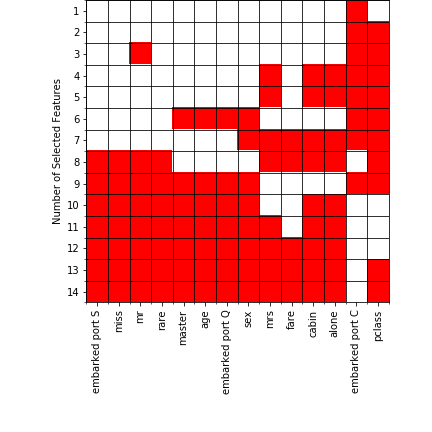

In [95]:
import matplotlib.colors as colors
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.1, 0.3, .9, .7])
ax.set_title("Best Feature Selection")
ax.set_ylabel('Number of Selected Features')
ax.set_xticks(np.arange(len(features)))
ax.set_xticklabels(features, rotation=90)
ax.set_yticks(np.arange(len(features)))
ax.set_yticklabels(np.arange(1, len(features)+1))
# Set a grid on minor ticks
ax.set_xticks(np.arange(-0.5, len(features)), minor=True)
ax.set_yticks(np.arange(-0.5, len(features)), minor=True)
ax.grid(which='minor', color='black')

ax.imshow(selected_features, cmap=colors.ListedColormap(['white', 'red']))


# Summary

# Feature Selection and Mutual Information
This section explains the math of mutual information.

As described above, to select the :math:`k` most relevant features, you might maximize
:math:`I({X_s}; Y)`, the MI between a set of :math:`k` features, :math:`X_s`, and the
variable of interest, :math:`Y`. Given :math:`N` features out of which you select
:math:`k`, maximize mutual information, I, as

${X_1, X_2, ...X_k} = \arg \max I(X_k; Y)$

by expanding,

$I(X_k;Y) = N^{-1} \sum_i \left\{ I(X_i;Y) + I(X_{k(i)};Y|X_i) \right\}$

Approximate the second term by assuming conditional independence:

$I(X_k;Y|X_i) \approx \sum_{j \in X_k(i)} I(X_j;Y|X_i)$

Using the following equations for Shannon entropy,

$H(X) = -\sum_x P(x)\mathrm{log}P(x)
    H(X|Y) = H(X,Y)-H(Y)$
    
You can then calculate all these terms as follows:

.. math::
     I(X;Y) = H(X)-H(X|Y)
     I(X;Y|Z) = H(X|Z)-H(X|Y,Z)
The approximated equation for MI can now be formed as a QUBO:

.. math:
    {X_1, X_2, ...X_k} = \arg \max \left\{MI - Penalty}
where the penalty is some multiple of :math:`\sum_{i} (x_i - k)^2` that enforces
the constraint of :math:`k` features.